In [81]:
import qiskit.tools.jupyter

%qiskit_version_table


# Saving, Loading Qiskit Machine Learning Models and Continuous Training

In the first part of this lecture we will cover how to:

* Generate a simple dataset, split it into training/test datasets and plot them
* Train and save a model
* Load a saved model and resume training
* Evaluate performance of models
* PyTorch hybrid models

First off, we start from the required imports. We'll heavily use SciKit-Learn on the data preparation step. In the next cell we also fix a random seed for reproducibility purposes.

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from qiskit_machine_learning.algorithms.classifiers import VQC

from IPython.display import clear_output

algorithm_globals.random_seed = 42

We will be using two quantum simulators, in particular, two instances of the `Sampler` primitive. We'll start training on the first one, then will resume training on the second one. The approach shown in this tutorial can be used to train a model on a real hardware available on the cloud and then re-use the model for inference on a local simulator.

In [83]:
sampler1 = Sampler()

sampler2 = Sampler()

## 1. Prepare a dataset

Next step is to prepare a dataset. Here, we generate some data in the same way as in other tutorials. The difference is that we apply some transformations to the generated data. We generates `40` samples, each sample has `2` features, so our features is an array of shape `(40, 2)`. Labels are obtained by summing up features by columns and if the sum is more than `1` then this sample is labeled as `1` and `0` otherwise.

In [84]:
num_samples = 40
num_features = 2
features = 2 * algorithm_globals.random.random([num_samples, num_features]) - 1
labels = 1 * (np.sum(features, axis=1) >= 0)  # in { 0,  1}

Then, we scale down our features into a range of `[0, 1]` by applying `MinMaxScaler` from SciKit-Learn. Model training convergence is better when this  transformation is applied.

In [85]:
features = MinMaxScaler().fit_transform(features)
features.shape

(40, 2)

Let's take a look at the features of the first `5` samples of our dataset after the transformation.

In [86]:
features[0:5, :]

array([[0.79067335, 0.44566143],
       [0.88072937, 0.7126244 ],
       [0.06741233, 1.        ],
       [0.7770372 , 0.80422817],
       [0.10351936, 0.45754615]])

We choose `VQC` or Variational Quantum Classifier as a model we will train. This model, by default, takes one-hot encoded labels, so we have to transform the labels that are in the set of `{0, 1}` into one-hot representation. We employ SciKit-Learn for this transformation as well. Please note that the input array must be reshaped to `(num_samples, 1)` first. The `OneHotEncoder` encoder does not work with 1D arrays and our labels is a 1D array. In this case a user must decide either an array has only one feature(our case!) or has one sample. Also, by default the encoder returns sparse arrays, but for dataset plotting it is easier to have dense arrays, so we set `sparse` to `False`. 

In [87]:
labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))
labels.shape

(40, 2)

Let's take a look at the labels of the first `5` labels of the dataset. The labels should be one-hot encoded.

In [88]:
labels[0:5, :]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

Now we split our dataset into two parts: a training dataset and a test one. As a rule of thumb, 80% of a full dataset should go into a training part and 20% into a test one. Our training dataset has `30` samples. The test dataset should be used only once, when a model is trained to verify how well the model behaves on unseen data. We employ `train_test_split` from SciKit-Learn.

In [89]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=30, random_state=algorithm_globals.random_seed
)
train_features.shape

(30, 2)

Now it is time to see how our dataset looks like. Let's plot it.

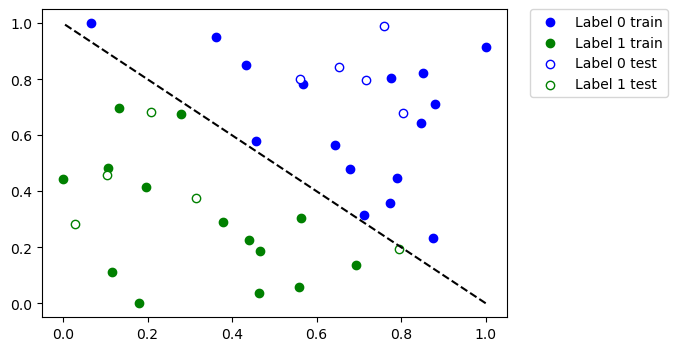

In [90]:
def plot_dataset():
    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 0), 0],
        train_features[np.where(train_labels[:, 0] == 0), 1],
        marker="o",
        color="b",
        label="Label 0 train",
    )
    plt.scatter(
        train_features[np.where(train_labels[:, 0] == 1), 0],
        train_features[np.where(train_labels[:, 0] == 1), 1],
        marker="o",
        color="g",
        label="Label 1 train",
    )

    plt.scatter(
        test_features[np.where(test_labels[:, 0] == 0), 0],
        test_features[np.where(test_labels[:, 0] == 0), 1],
        marker="o",
        facecolors="w",
        edgecolors="b",
        label="Label 0 test",
    )
    plt.scatter(
        test_features[np.where(test_labels[:, 0] == 1), 0],
        test_features[np.where(test_labels[:, 0] == 1), 1],
        marker="o",
        facecolors="w",
        edgecolors="g",
        label="Label 1 test",
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.plot([1, 0], [0, 1], "--", color="black")


plot_dataset()
plt.show()

On the plot above we see:

* Solid <span style="color:blue">blue</span> dots are the samples from the training dataset labeled as `0`
* Empty <span style="color:blue">blue</span> dots are the samples from the test dataset labeled as `0`
* Solid <span style="color:green">green</span> dots are the samples from the training dataset labeled as `1`
* Empty <span style="color:green">green</span> dots are the samples from the test dataset labeled as `1`

We'll train our model using solid dots and verify it using empty dots.

## 2. Train a model and save it

We'll train our model in two steps. On the first step we train our model in `20` iterations.

In [91]:
maxiter = 20

Create an empty array for callback to store values of the objective function.

In [92]:
objective_values = []

We re-use a callback function from the Neural Network Classifier & Regressor tutorial to plot iteration versus objective function value with some minor tweaks to plot objective values at each step.

In [93]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(_, objective_value):
    clear_output(wait=True)
    objective_values.append(objective_value)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")

    stage1_len = np.min((len(objective_values), maxiter))
    stage1_x = np.linspace(1, stage1_len, stage1_len)
    stage1_y = objective_values[:stage1_len]

    stage2_len = np.max((0, len(objective_values) - maxiter))
    stage2_x = np.linspace(maxiter, maxiter + stage2_len - 1, stage2_len)
    stage2_y = objective_values[maxiter : maxiter + stage2_len]

    plt.plot(stage1_x, stage1_y, color="orange")
    plt.plot(stage2_x, stage2_y, color="purple")
    plt.show()


plt.rcParams["figure.figsize"] = (12, 6)

As mentioned above we train a `VQC` model and set `COBYLA` as an optimizer with a chosen value of the `maxiter` parameter. Then we evaluate performance of the model to see how well it was trained. Then we save this model for a file. On the second step we load this model and will continue to work with it.

Here, we manually construct an ansatz to fix an initial point where to start optimization from.

In [94]:
original_optimizer = COBYLA(maxiter=maxiter)

ansatz = RealAmplitudes(num_features)
initial_point = np.asarray([0.5] * ansatz.num_parameters)

We create a model and set a sampler to the first sampler we created earlier.

In [95]:
original_classifier = VQC(
    ansatz=ansatz, optimizer=original_optimizer, callback=callback_graph, sampler=sampler1
)

Now it is time to train the model.

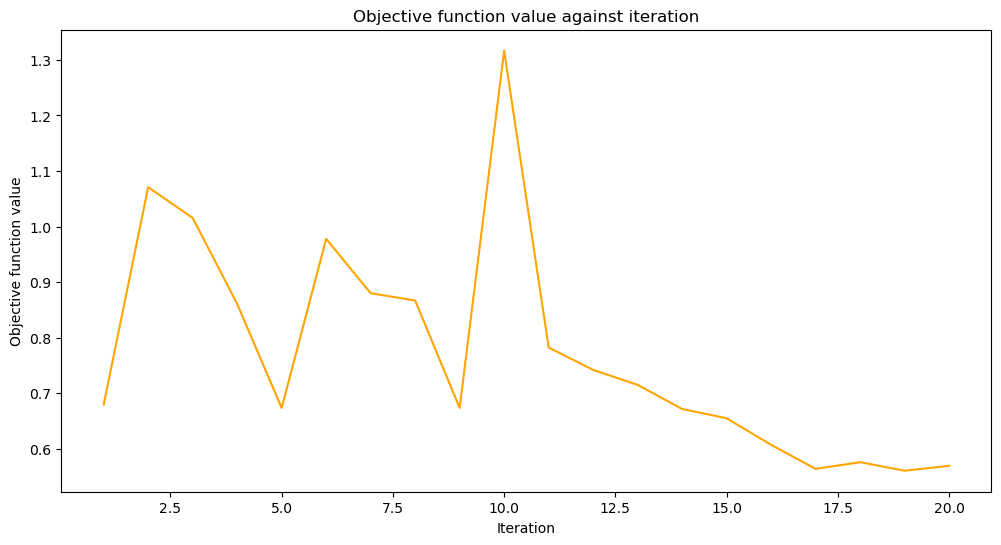

In [96]:
original_classifier.fit(train_features, train_labels)

Let's see how well our model performs after the first step of training.

In [97]:
print("Train score", original_classifier.score(train_features, train_labels))
print("Test score ", original_classifier.score(test_features, test_labels))

Train score 0.8333333333333334
Test score  0.8


Next, we save the model. You may choose any file name you want. Please note that the `save` method does not append an extension if it is not specified in the file name.

In [98]:
original_classifier.save("vqc_classifier.model")

## 3. Load a model and continue training

To load a model a user have to call a class method `load` of the corresponding model class. In our case it is `VQC`. We pass the same file name we used in the previous section where we saved our model.

In [99]:
loaded_classifier = VQC.load("vqc_classifier.model")

Next, we want to alter the model in a way it can be trained further and on another simulator. To do so, we set the `warm_start` property. When it is set to `True` and `fit()` is called again the model uses weights from previous fit to start a new fit. We also set the `sampler` property of the underlying network to the second instance of the `Sampler` primitive we created in the beginning of the tutorial. Finally, we create and set a new optimizer with `maxiter` is set to `80`, so the total number of iterations is `100`.

In [100]:
loaded_classifier.warm_start = True
loaded_classifier.neural_network.sampler = sampler2
loaded_classifier.optimizer = COBYLA(maxiter=80)

Now we continue training our model from the state we finished in the previous section.

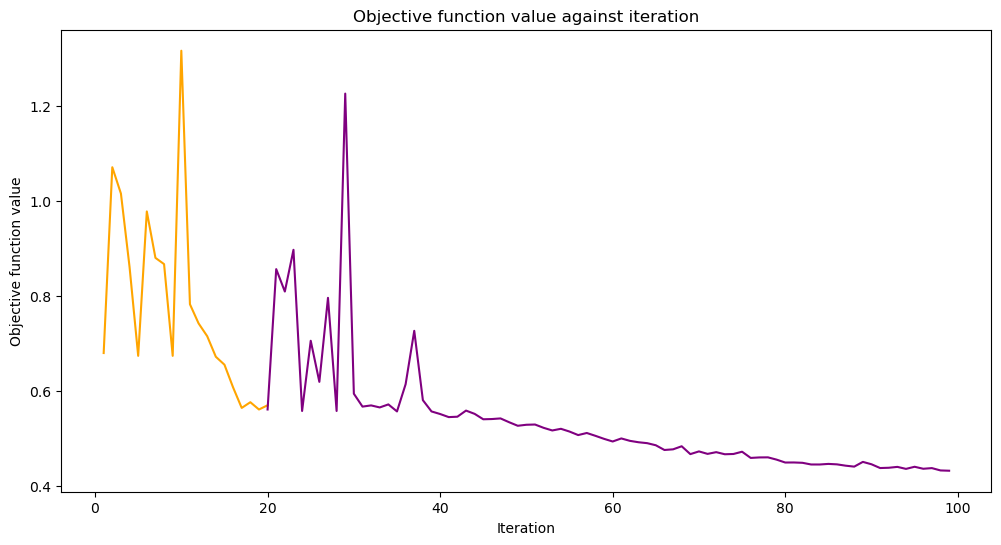

In [101]:
loaded_classifier.fit(train_features, train_labels)

In [102]:
print("Train score", loaded_classifier.score(train_features, train_labels))
print("Test score", loaded_classifier.score(test_features, test_labels))

Train score 0.9
Test score 0.8


Let's see which data points were misclassified. First, we call `predict` to infer predicted values from the training and test features.

In [103]:
train_predicts = loaded_classifier.predict(train_features)
test_predicts = loaded_classifier.predict(test_features)

Plot the whole dataset and the highlight the points that were classified incorrectly.

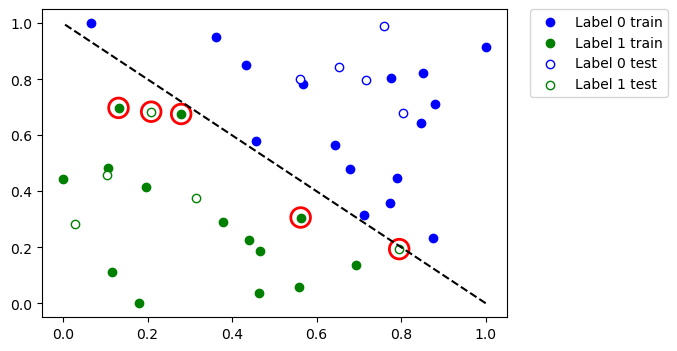

In [104]:
# return plot to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

plot_dataset()

# plot misclassified data points
plt.scatter(
    train_features[np.all(train_labels != train_predicts, axis=1), 0],
    train_features[np.all(train_labels != train_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)
plt.scatter(
    test_features[np.all(test_labels != test_predicts, axis=1), 0],
    test_features[np.all(test_labels != test_predicts, axis=1), 1],
    s=200,
    facecolors="none",
    edgecolors="r",
    linewidths=2,
)

So, if you have a large dataset or a large model you can train it in multiple steps as shown in this tutorial.

# Torch Connector and Hybrid QNNs

This part introduces the `TorchConnector` class, and demonstrates how it allows for a natural integration of any `NeuralNetwork` from Qiskit Machine Learning into a PyTorch workflow. `TorchConnector` takes a `NeuralNetwork` and makes it available as a PyTorch `Module`. The resulting module can be seamlessly incorporated into PyTorch classical architectures and trained jointly without additional considerations, enabling the development and testing of novel **hybrid quantum-classical** machine learning architectures.

## Content:

[Part 1: Simple Classification & Regression](#Part-1:-Simple-Classification-&-Regression)

The first part of this tutorial shows how quantum neural networks can be trained using PyTorch's automatic differentiation engine (`torch.autograd`, [link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)) for simple classification and regression tasks. 

1. [Classification](#1.-Classification)
    1. Classification with PyTorch and `EstimatorQNN`
    2. Classification with PyTorch and `SamplerQNN`
2. [Regression](#2.-Regression)
    1. Regression with PyTorch and `EstimatorQNN`

[Part 2: MNIST Classification, Hybrid QNNs](#Part-2:-MNIST-Classification,-Hybrid-QNNs)

The second part of this tutorial illustrates how to embed a (Quantum) `NeuralNetwork` into a target PyTorch workflow (in this case, a typical CNN architecture) to classify MNIST data in a hybrid quantum-classical manner.

***

In [105]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

## Part 1: Simple Classification & Regression

### 1. Classification

First, we show how `TorchConnector` allows to train a Quantum `NeuralNetwork` to solve a classification tasks using PyTorch's automatic differentiation engine. In order to illustrate this, we will perform **binary classification** on a randomly generated dataset.

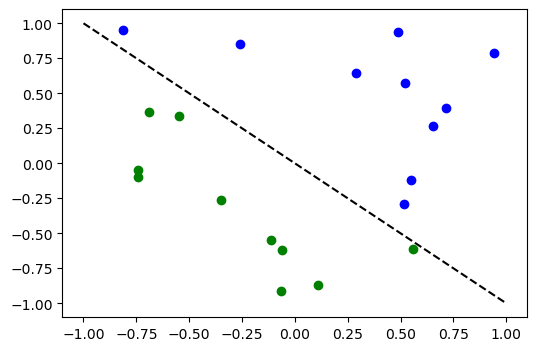

In [106]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for SamplerQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for EstimatorQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

#### A. Classification with PyTorch and  `EstimatorQNN`

Linking an `EstimatorQNN` to PyTorch is relatively straightforward. Here we illustrate this by using the `EstimatorQNN` constructed from a feature map and an ansatz.

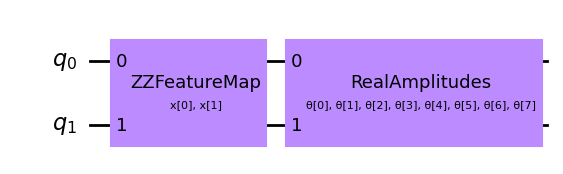

In [107]:
# Set up a circuit
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw("mpl")

In [108]:
# Setup QNN
qnn1 = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

Initial weights:  [-0.01256962  0.06653564  0.04005302 -0.03752667  0.06645196  0.06095287
 -0.02250432 -0.04233438]


In [109]:
# Test with a single input
model1(X_[0, :])

tensor([-0.3285], grad_fn=<_TorchNNFunctionBackward>)

##### Optimizer
The choice of optimizer for training any machine learning model can be crucial in determining the success of our training's outcome. When using `TorchConnector`, we get access to all of the optimizer algorithms defined in the [`torch.optim`] package ([link](https://pytorch.org/docs/stable/optim.html)). Some of the most famous algorithms used in popular machine learning architectures include *Adam*, *SGD*, or *Adagrad*. However, for this tutorial we will be using the L-BFGS algorithm (`torch.optim.LBFGS`), one of the most well know second-order optimization algorithms for numerical optimization. 

##### Loss Function
As for the loss function, we can also take advantage of PyTorch's pre-defined modules from `torch.nn`, such as the [Cross-Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) or [Mean Squared Error](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) losses.


**💡 Clarification :** 
In classical machine learning, the general rule of thumb is to apply a Cross-Entropy loss to classification tasks, and MSE loss to regression tasks. However, this recommendation is given under the assumption that the output of the classification network is a class probability value in the $[0, 1]$ range (usually this is achieved  through a Softmax layer). Because the following example for `EstimatorQNN` does not include such layer, and we don't apply any mapping to the output (the following section shows an example of application of parity mapping with `SamplerQNN`s), the QNN's output can take any value in the range $[-1, 1]$. In case you were wondering, this is the reason why this particular example uses MSELoss for classification despite it not being the norm (but we encourage you to experiment with different loss functions and see how they can impact training results). 

In [110]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

25.535646438598633
22.696760177612305
20.039228439331055
19.68790626525879
19.267208099365234
19.02537727355957
18.15471076965332
17.337860107421875
19.082786560058594
17.07333755493164
16.218456268310547
14.992587089538574
14.929342269897461
14.914535522460938
14.907636642456055
14.902364730834961
14.90213394165039
14.902111053466797
14.902111053466797


tensor(25.5356, grad_fn=<MseLossBackward0>)

Accuracy: 0.8


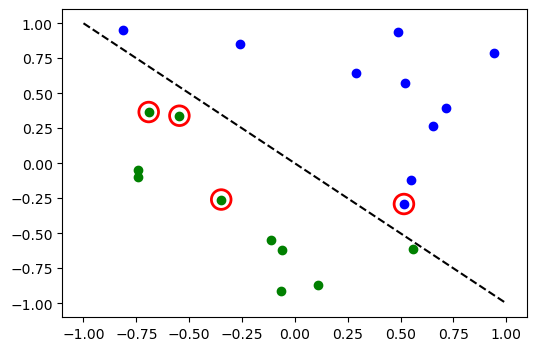

In [111]:
# Evaluate model and compute accuracy
model1.eval()
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

The red circles indicate wrongly classified data points.

#### B. Classification with PyTorch and `SamplerQNN`

Linking a `SamplerQNN` to PyTorch requires a bit more attention than `EstimatorQNN`. Without the correct setup, backpropagation is not possible. 

In particular, we must make sure that we are returning a dense array of probabilities in the network's forward pass (`sparse=False`). This parameter is set up to `False` by default, so we just have to make sure that it has not been changed.

**⚠️ Attention:** 
If we define a custom interpret function ( in the example: `parity`), we must remember to explicitly provide the desired output shape ( in the example: `2`). For more info on the initial parameter setup for `SamplerQNN`, please check out the [official qiskit documentation](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html).

In [112]:
# Define feature map and ansatz
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

# Define quantum circuit of num_qubits = input dim
# Append feature map and ansatz
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Define SamplerQNN and initial setup
parity = lambda x: "{:b}".format(x).count("1") % 2  # optional interpret function
output_shape = 2  # parity = 0, 1
qnn2 = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

Initial weights:  [ 0.0364991  -0.0720495  -0.06001836 -0.09852755]


For a reminder on optimizer and loss function choices, you can go back to [this section](#Optimizer).

In [113]:
# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method (explained in previous section)
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_), y01_)  # Calculate loss
    loss.backward()  # Backward pass

    print(loss.item())  # Print loss
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

0.6925069093704224
0.6881508231163025
0.6516684293746948
0.6485998034477234
0.6394745111465454
0.7055226564407349
0.6669210195541382
0.6787251234054565
0.6803979873657227
0.695716381072998
0.7132896184921265
0.7562533020973206
0.7432097792625427
0.6605831384658813
0.6825891137123108
0.6667172312736511
0.7186322808265686
0.748259425163269
0.6837981939315796
0.7127187252044678


Accuracy: 0.45


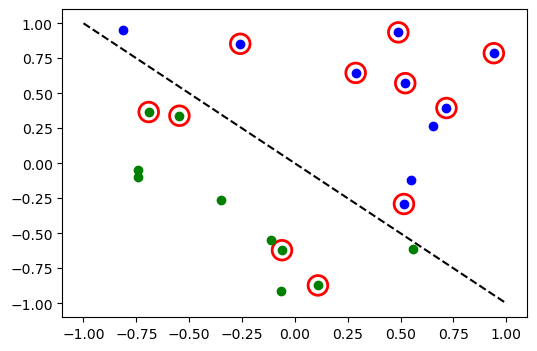

In [114]:
# Evaluate model and compute accuracy
model2.eval()
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y01) / len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

The red circles indicate wrongly classified data points.

### 2. Regression 

We use a model based on the `EstimatorQNN` to also illustrate how to perform a regression task. The chosen dataset in this case is randomly generated following a sine wave. 

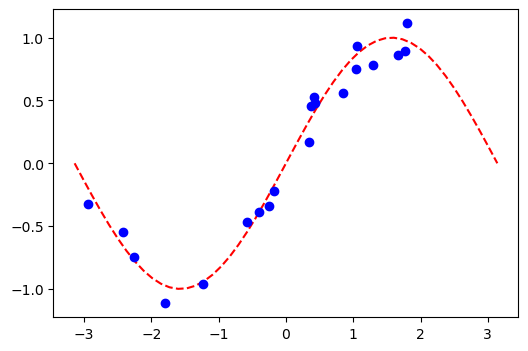

In [115]:
# Generate random dataset

num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

#### A. Regression with PyTorch and `EstimatorQNN`

The network definition and training loop will be analogous to those of the classification task using `EstimatorQNN`. In this case, we define our own feature map and ansatz, but let's do it a little different.

In [116]:
# Construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# Construct simple parameterized ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Construct QNN
qnn3 = EstimatorQNN(circuit=qc, input_params=[param_x], weight_params=[param_y])

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

For a reminder on optimizer and loss function choices, you can go back to [this section](#Optimizer).

In [117]:
# Define optimizer and loss function
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model3.train()  # set model to training mode

# Define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model3(Tensor(X)), Tensor(y))  # Compute batch loss
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer
optimizer.step(closure)

14.947757720947266
2.948650360107422
8.952412605285645
0.37905153632164
0.24995625019073486
0.2483610212802887
0.24835753440856934


tensor(14.9478, grad_fn=<MseLossBackward0>)

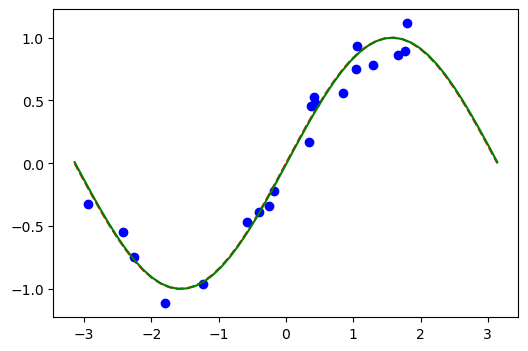

In [118]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

# Plot data
plt.plot(X, y, "bo")

# Plot fitted line
model3.eval()
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()

***

## Part 2: MNIST Classification, Hybrid QNNs

In this second part, we show how to leverage a hybrid quantum-classical neural network using `TorchConnector`, to perform a more complex image classification task on the MNIST handwritten digits dataset. 

For a more detailed (pre-`TorchConnector`) explanation on hybrid quantum-classical neural networks, you can check out the corresponding section in the [Qiskit Textbook](https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html).

In [119]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

### Step 1: Defining Data-loaders for train and test

We take advantage of the `torchvision` [API](https://pytorch.org/vision/stable/datasets.html) to directly load a subset of the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) and define torch `DataLoader`s ([link](https://pytorch.org/docs/stable/data.html)) for train and test.

In [120]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:37<00:00, 264857.95it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13201361.58it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:03<00:00, 532814.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3876786.48it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


If we perform a quick visualization we can see that the train dataset consists of images of handwritten 0s and 1s.

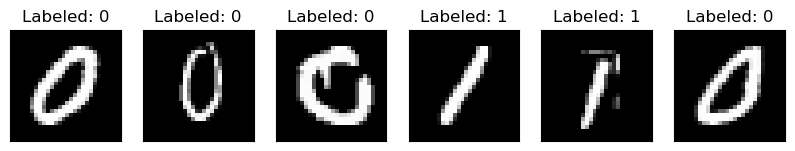

In [121]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [122]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

### Step 2: Defining the QNN and Hybrid Model

This second step shows the power of the `TorchConnector`. After defining our quantum neural network layer (in this case, a `EstimatorQNN`), we can embed it into a layer in our torch `Module` by initializing a torch connector as `TorchConnector(qnn)`.

**⚠️ Attention:**
In order to have an adequate gradient backpropagation in hybrid models,  we MUST set the initial parameter `input_gradients` to TRUE during the qnn initialization.

In [123]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [124]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

### Step 3: Training

In [125]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -1.1630
Training [20%]	Loss: -1.5294
Training [30%]	Loss: -1.7855
Training [40%]	Loss: -1.9863
Training [50%]	Loss: -2.2257
Training [60%]	Loss: -2.4513
Training [70%]	Loss: -2.6758
Training [80%]	Loss: -2.8832
Training [90%]	Loss: -3.1006
Training [100%]	Loss: -3.3061


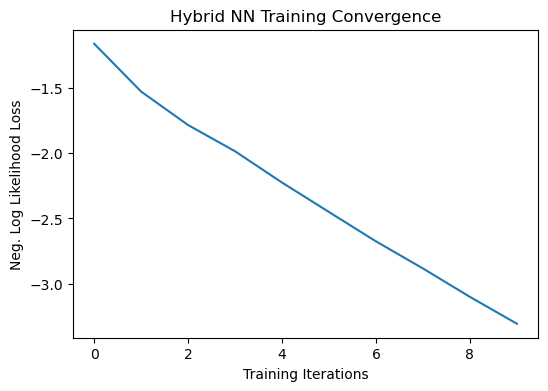

In [126]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

Now we'll save the trained model, just to show how a hybrid model can be saved and re-used later for inference. To save and load hybrid models, when using the TorchConnector, follow the PyTorch recommendations of saving and loading the models.

In [127]:
torch.save(model4.state_dict(), "model4.pt")

### Step 4: Evaluation

We start from recreating the model and loading the state from the previously saved file. You create a QNN layer using another simulator or a real hardware. So, you can train a model on real hardware available on the cloud and then for inference use a simulator or vice verse. For a sake of simplicity we create a new quantum neural network in the same way as above.

In [128]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [129]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -3.3585
	Accuracy: 100.0%


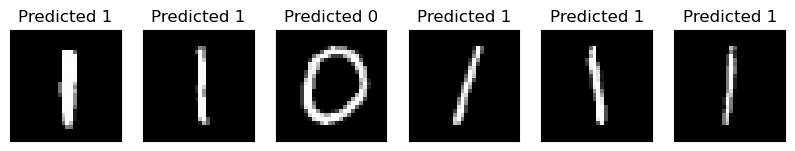

In [130]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

🎉🎉🎉🎉
**You are now able to experiment with your own hybrid datasets and architectures using Qiskit Machine Learning.** 
**Good Luck!**

# PyTorch qGAN Implementation


## Overview

This tutorial introduces step-by-step how to build a PyTorch-based Quantum Generative Adversarial Network algorithm.

The tutorial is structured as follows:

1. [Introduction](#1.-Introduction)
2. [Data and Represtation](#2.-Data-and-Representation)
3. [Definitions of the Neural Networks](#3.-Definitions-of-the-Neural-Networks)
4. [Setting up the Training Loop](#4.-Setting-up-the-Training-Loop)
5. [Model Training](#5.-Model-Training)
6. [Results: Cumulative Density Functions](#6.-Results:-Cumulative-Density-Functions)
7. [Conclusion](#7.-Conclusion)

## 1. Introduction

The qGAN \[1\] is a hybrid quantum-classical algorithm used for generative modeling tasks. The algorithm uses the interplay of a quantum generator $G_{\theta}$, i.e., an ansatz (parametrized quantum circuit), and a classical discriminator $D_{\phi}$, a neural network, to learn the underlying probability distribution given training data.

The generator and discriminator are trained in alternating optimization steps, where the generator aims at generating probabilities that will be classified by the discriminator as training data values (i.e, probabilities from the real training distribution), and the discriminator tries to differentiate between original distribution and probabilities from the generator (in other words, telling apart the real and generated distributions). The final goal is for the quantum generator to learn a representation for the target probability distribution.
The trained quantum generator can, thus, be used to load a quantum state which is an approximate model of the target distribution.

**References:**

\[1\] Zoufal et al., [Quantum Generative Adversarial Networks for learning and loading random distributions](https://www.nature.com/articles/s41534-019-0223-2)

### 1.1. qGANs for Loading Random Distributions

Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn a random distribution and to load it directly into a quantum state:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$.

The aim of the qGAN training is to generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to [Quantum Generative Adversarial Networks for Learning and Loading Random Distributions](https://arxiv.org/abs/1904.00043) _Zoufal, Lucchi, Woerner_ \[2019\].

For an example of how to use a trained qGAN in an application, the pricing of financial derivatives, please see the
[Option Pricing with qGANs](https://qiskit.org/ecosystem/finance/tutorials/10_qgan_option_pricing.html) tutorial.

## 2. Data and Representation

First, we need to load our training data $X$.

In this tutorial, the training data is given by a 2D multivariate normal distribution.

The goal of the generator is to learn how to represent such distribution, and the trained generator should correspond to an $n$-qubit quantum state
\begin{equation}
|g_{\text{trained}}\rangle=\sum\limits_{j=0}^{k-1}\sqrt{p_{j}}|x_{j}\rangle,
\end{equation}
where the basis states $|x_{j}\rangle$ represent the data items in the training data set
$X={x_0, \ldots, x_{k-1}}$ with $k\leq 2^n$ and $p_j$ refers to the sampling probability
of $|x_{j}\rangle$.

To facilitate this representation, we need to map the samples from the multivariate
normal distribution to discrete values. The number of values that can be represented
depends on the number of qubits used for the mapping.
Hence, the data resolution is defined by the number of qubits.
If we use $3$ qubits to represent one feature, we have $2^3 = 8$ discrete values.

We first begin by fixing seeds in the random number generators for reproducibility of the outcome in this tutorial.

In [131]:
import torch
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)  # suppress output

We fix the number of dimensions, the discretization number and compute the number of qubits required as $2^3 = 8$.

In [132]:
import numpy as np

num_dim = 2
num_discrete_values = 8
num_qubits = num_dim * int(np.log2(num_discrete_values))

Then, we prepare a discrete distribution from the continuous 2D normal distribution. We evaluate the continuous probability density function (PDF) on the grid $(-2, 2)^2$ with a discretization of $8$ values per feature. Thus, we have $64$ values of the PDF. Since this will be a discrete distribution we normalize the obtained probabilities.

In [133]:
from scipy.stats import multivariate_normal

coords = np.linspace(-2, 2, num_discrete_values)
rv = multivariate_normal(mean=[0.0, 0.0], cov=[[1, 0], [0, 1]], seed=algorithm_globals.random_seed)
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])
prob_data = rv.pdf(grid_elements)
prob_data = prob_data / np.sum(prob_data)

Let's visualize our distribution. It is a nice bell-shaped bivariate normal distribution on a discrete grid.

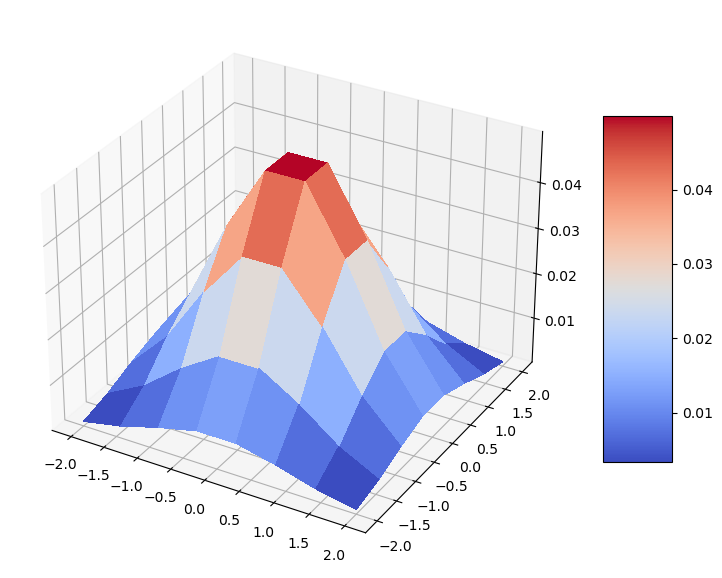

In [134]:
import matplotlib.pyplot as plt
from matplotlib import cm

mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
prob_grid = np.reshape(prob_data, grid_shape)
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## 3. Definitions of the Neural Networks
In this section we define two neural networks as described above:

- A quantum generator as a quantum neural network.
- A classical discriminator as a PyTorch-based neural network.

### 3.1. Definition of the quantum neural network ansatz

Now, we define the parameterized quantum circuit $G\left(\boldsymbol{\theta}\right)$ with $\boldsymbol{\theta} = {\theta_1, ..., \theta_k}$ which will be used in our quantum generator.

To implement the quantum generator, we choose a hardware efficient ansatz with $6$ repetitions. The ansatz implements $R_Y$, $R_Z$ rotations and $CX$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should be more than $1$ because higher circuit depths enable the representation of more complex structures. Here, we construct quite a deep circuit with a large number of parameters to be able to adequately capture and represent the distribution.

In [135]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6)
qc.compose(ansatz, inplace=True)

Let's draw our circuit and see what it looks like. On the plot we may notice a pattern that appears $6$ times.

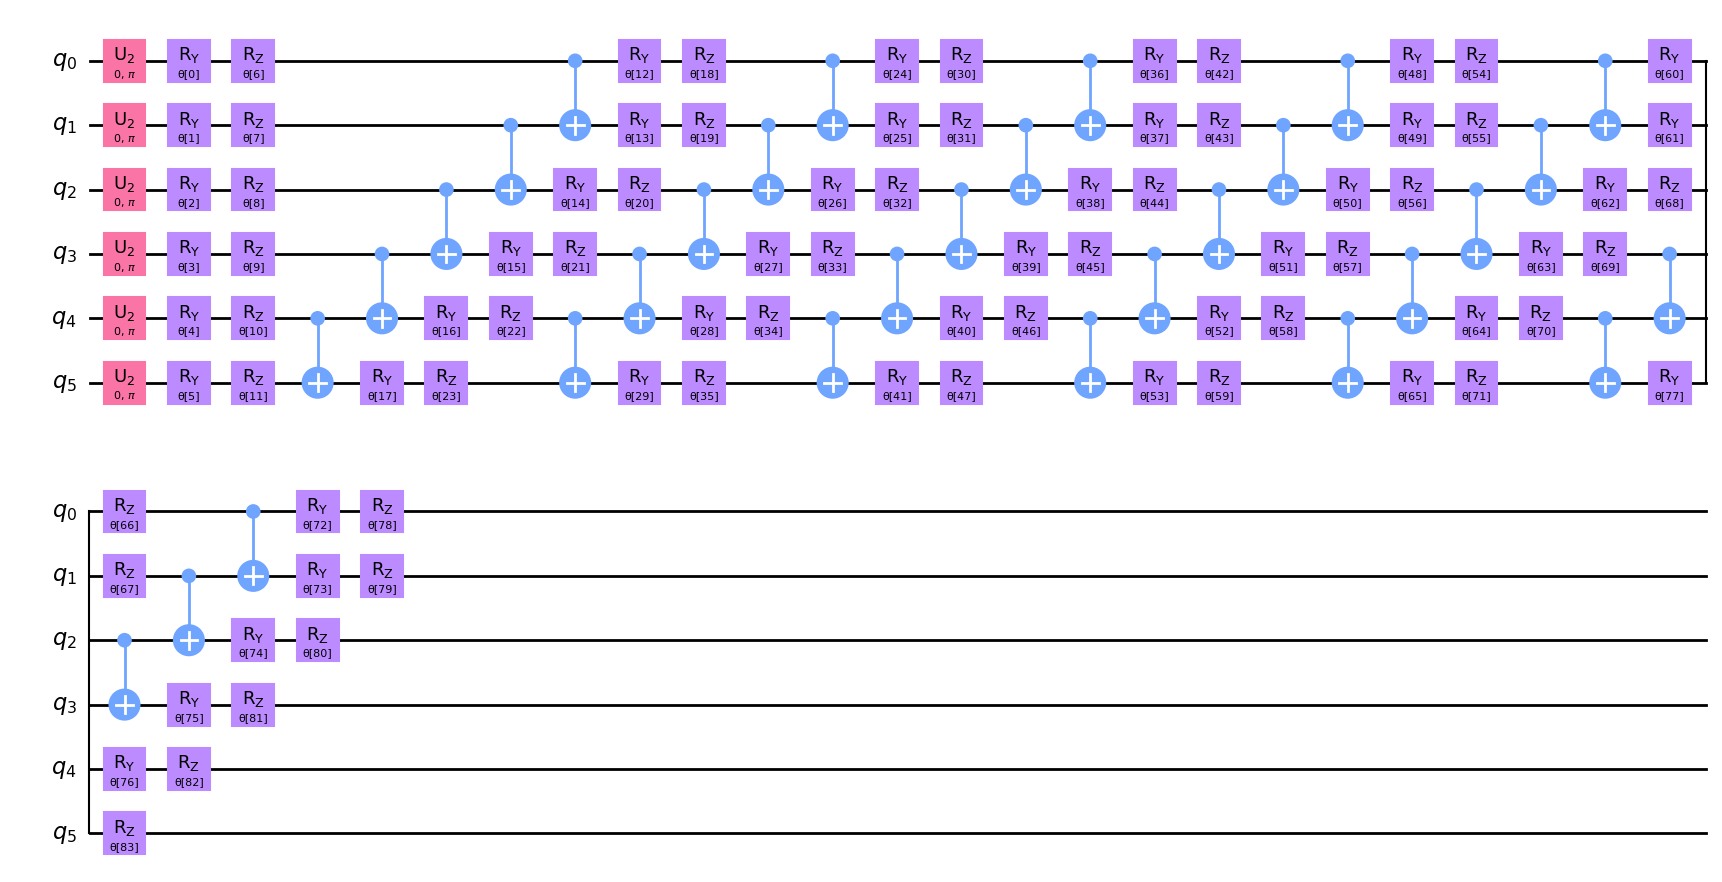

In [136]:
qc.decompose().draw("mpl")

Let's print the number of trainable parameters.

In [137]:
qc.num_parameters

84

### 3.2. Definition of the quantum generator

We start defining the generator by creating a sampler for the ansatz. The reference implementation is a statevector-based implementation, thus it returns exact probabilities as a result of circuit execution. We add the `shots` parameter to add some noise to the results. In this case the implementation samples probabilities from the multinomial distribution constructed from the measured quasi probabilities. And as usual we fix the seed for reproducibility purposes.

In [138]:
from qiskit.primitives import Sampler

shots = 10000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

Next, we define a function that creates the quantum generator from a given parameterized quantum circuit. Inside this function we create a neural network that returns the quasi probability distribution evaluated by the underlying Sampler. We fix `initial_weights` for reproducibility purposes. In the end we wrap the created quantum neural network in `TorchConnector` to make use of PyTorch-based training.

In [139]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN


def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

### 3.3. Definition of the classical discriminator

Next, we define a PyTorch-based classical neural network that represents the classical discriminator. The underlying gradients can be automatically computed with PyTorch.

In [140]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

### 3.4. Create a generator and a discriminator

Now we create a generator and a discriminator.

In [141]:
generator = create_generator()
discriminator = Discriminator(num_dim)

## 4. Setting up the Training Loop
In this section we set up:

- A loss function for the generator and discriminator.
- Optimizers for both.
- A utility plotting function to visualize training process.

### 4.1. Definition of the loss functions
We want to train the generator and the discriminator with binary cross entropy as the loss function:
$$L\left(\boldsymbol{\theta}\right)=\sum_jp_j\left(\boldsymbol{\theta}\right)\left[y_j\log(x_j) + (1-y_j)\log(1-x_j)\right],$$
where $x_j$ refers to a data sample and $y_j$ to the corresponding label.

Since PyTorch's `binary_cross_entropy` is not differentiable with respect to weights, we implement the loss function manually to be able to evaluate gradients.

In [142]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

### 4.2. Definition of the optimizers
In order to train the generator and discriminator, we need to define optimization schemes. In the following, we employ a momentum based optimizer called Adam, see [Kingma et al., Adam: A method for stochastic optimization](https://arxiv.org/abs/1412.6980) for more details.

In [143]:
from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

### 4.3. Visualization of the training process
We will visualize what is happening during the training by plotting the evolution of the generator's and the discriminator's loss functions during the training, as well as the progress in the relative entropy between the trained and the target distribution. We define a function that plots the loss functions and relative entropy. We call this function once an epoch of training is complete.

Visualization of the training process begins when training data is collected across two epochs.

In [144]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

## 5. Model Training
In the training loop we monitor not only loss functions, but relative entropy as well. The relative entropy describes a distance metric for distributions. Hence, we can use it to benchmark how close/far away the trained distribution is from the target distribution.

Now, we are ready to train our model. It may take some time to train the model so be patient.

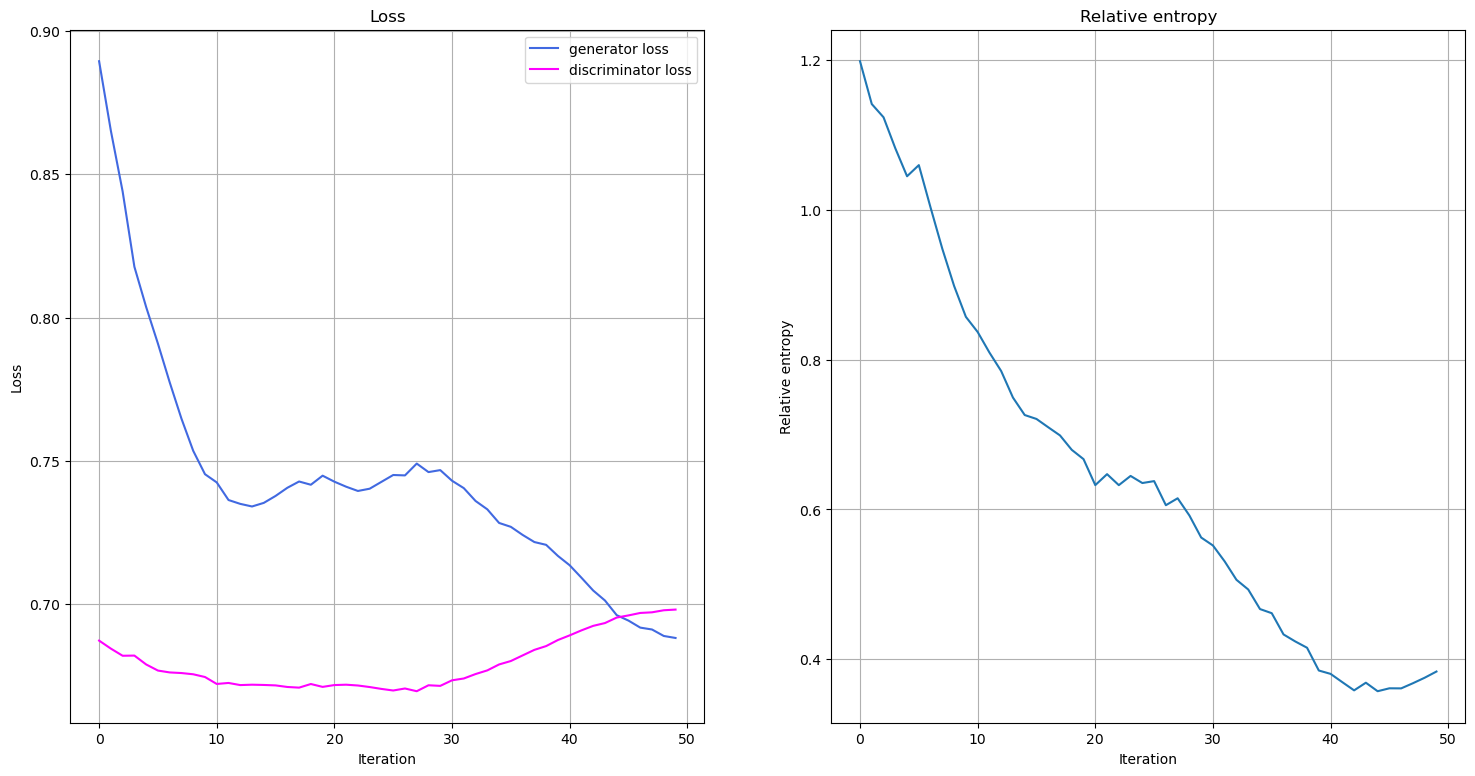

Fit in 121.72 sec


In [145]:
import time
from scipy.stats import multivariate_normal, entropy

n_epochs = 50

num_qnn_outputs = num_discrete_values**num_dim

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

## 6. Results: Cumulative Density Functions
In this section we compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

First, we generate a new probability distribution with PyTorch autograd turned off as we are not going to train the model anymore.

In [146]:
with torch.no_grad():
    generated_probabilities = generator().numpy()

And then, we plot the cumulative distribution functions of the generated distribution, original distribution, and the difference between them. Please, be careful, the scale on the third plot **is not the same** as on the first and second plot, and the actual difference between the two plotted CDFs is pretty small.

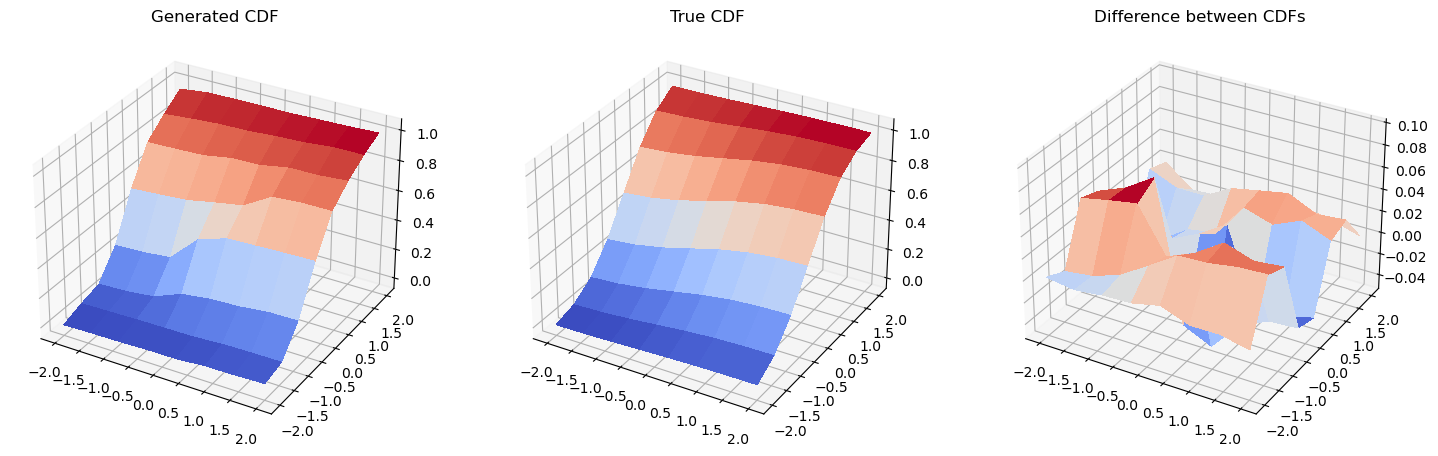

In [147]:
fig = plt.figure(figsize=(18, 9))

# Generated CDF
gen_prob_grid = np.reshape(np.cumsum(generated_probabilities), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# Real CDF
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()

## 7. Conclusion

Quantum generative adversarial networks employ the interplay of a generator and discriminator to map an approximate representation of a probability distribution underlying given data samples into a quantum channel. This tutorial presents a self-standing PyTorch-based qGAN implementation where the generator is given by a quantum channel, i.e., a variational quantum circuit, and the discriminator by a classical neural network, and discusses the application of efficient learning and loading of generic probability distributions into quantum states. The loading requires $\mathscr{O}\left(poly\left(n\right)\right)$ gates and can thus enable the use of potentially advantageous quantum algorithms.